In [1]:
import tensorflow as tf
from carrim import PhysicalModel, RIM
from carrim.models import CNN, Model
import os
import json
from argparse import Namespace
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from tqdm import tqdm

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

2022-07-08 09:45:41.031529: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-08 09:45:41.031558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fortytwo): /proc/driver/nvidia/version does not exist
2022-07-08 09:45:41.033207: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = os.path.join("../models/CNN_g1_043_lr0.0001_dr0.9_inceptionV3_220429122436") # 1
# model = os.path.join("../models/CNN_g1_037_lr0.0001_dr1.0_perreault_levasseur2016_220429122436") # 2 ish
# model = os.path.join("../models/CNN_g1_093_lr0.0001_dr0.9_resnet50_220429180730") # best resnet

with open(model + "/cnn_model_hparams.json", "r") as f:
    hparams = json.load(f)
with open(model + "/script_params.json", "r") as f:
    args = json.load(f)
args = Namespace(**args)

cnn = CNN(**hparams)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=cnn)
checkpoint_manager = tf.train.CheckpointManager(ckpt, model, max_to_keep=1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

phys = PhysicalModel(
        pixels=args.pixels,
        image_fov=args.image_fov,
        src_fov=args.src_fov,
        psf_cutout_size=args.psf_cutout_size,
        r_ein_min=args.r_ein_min,
        r_ein_max=args.r_ein_max,
        n_min=args.n_min,
        n_max=args.n_max,
        r_eff_min=args.r_eff_min,
        r_eff_max=args.r_eff_max,
        max_gamma=args.max_gamma,
        max_ellipticity=args.max_ellipticity,
        max_lens_shift=args.max_lens_shift,
        max_source_shift=args.max_source_shift,
        noise_rms_min=1e-2,
        noise_rms_max=2e-2,
        noise_rms_mean=1.5e-2,
        noise_rms_std=0.1e-2,
        psf_fwhm_min=args.psf_fwhm_min,
        psf_fwhm_max=args.psf_fwhm_max,
        psf_fwhm_std=args.psf_fwhm_std,
        psf_fwhm_mean=args.psf_fwhm_mean,
        sersic_i_eff=100
)

In [3]:
N = 100
B = 10

true = []
pred = []
ys = []
for batch in tqdm(range(N//B)):
    obs, params, noise_rms, psf_fwhm = phys.draw_sersic_batch(B)
    true.append(params.numpy())
    pred.append(phys.model_to_physical(cnn(obs).numpy()))
    ys.append(obs)
    sigmas.append(noise_rms.numpy())
true = np.concatenate(true, axis=0)
pred = np.concatenate(pred, axis=0)
ys = tf.concat(ys, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.84it/s]


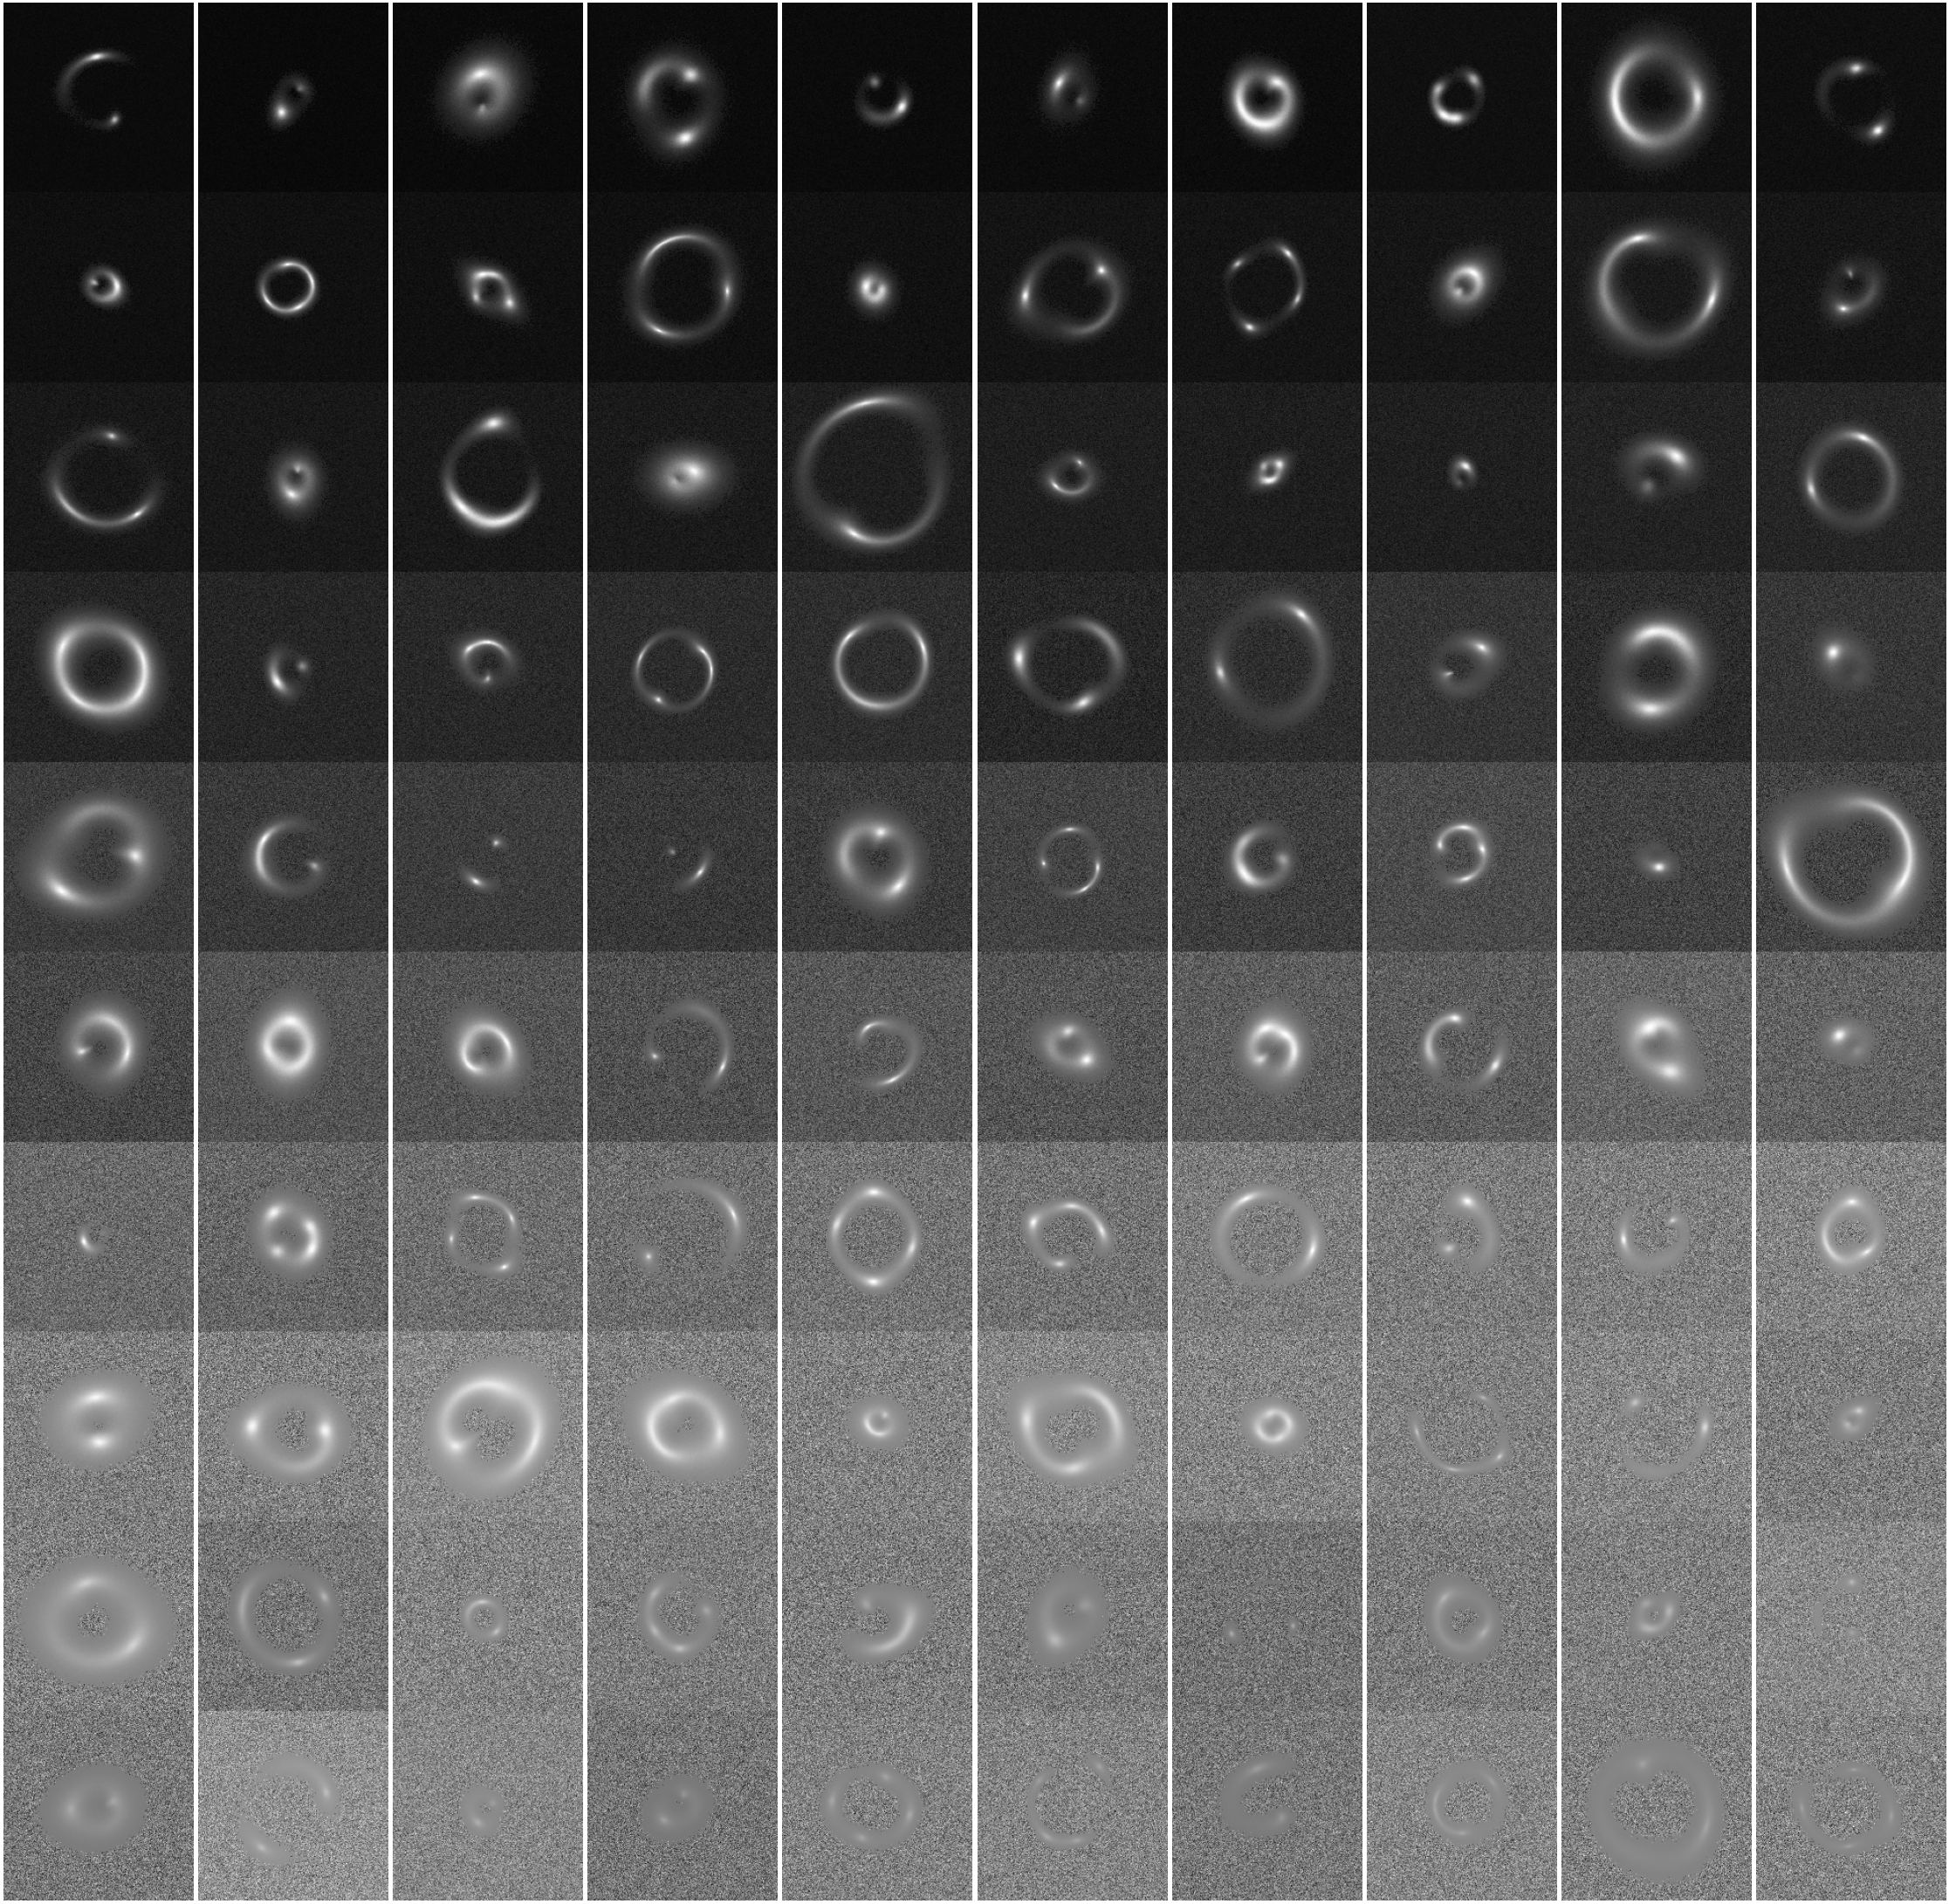

In [51]:
fig, axs = plt.subplots(10, 10, figsize=(40, 40))
sigmas = np.logspace(-2, 0, 100)
for i in range(10):
    for j in range(10):
        k = i * 10 + j
#         show = tf.cast((ys[k, ..., 0] > 3*sigmas[k]), tf.float32)
        mask = tf.cast(ys[k, ..., 0] > 3 * 1.5e-2, tf.float32)
        show = ys[k, ..., 0] *  mask
        show += (1 - mask) * tf.random.normal(shape=ys[k, ..., 0].shape, stddev=sigmas[k])
        axs[i, j].imshow(show, cmap="gray")
        axs[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0)

In [44]:
N = 100

true = []
pred_baseline = []
pred_sigmas = [[] for i in range(N)]
for batch in tqdm(range(N)):
    obs, params, noise_rms, psf_fwhm = phys.draw_sersic_batch(1)
    true.append(params.numpy())
    pred_baseline.append(cnn(obs).numpy())
    for sigma in sigmas:
        mask = tf.cast(obs > 3 * noise_rms, tf.float32)
        new_obs = obs *  mask
        new_obs += (1 - mask) * tf.random.normal(shape=obs.shape, stddev=sigma)
        pred_sigmas[batch].append(cnn(new_obs).numpy())
true = np.concatenate(true, axis=0)
pred_baseline = np.concatenate(pred_baseline, axis=0)
pred_sigmas = np.stack([np.concatenate(z, axis=0) for z in pred_sigmas], axis=0)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:27<00:00,  8.07s/it]


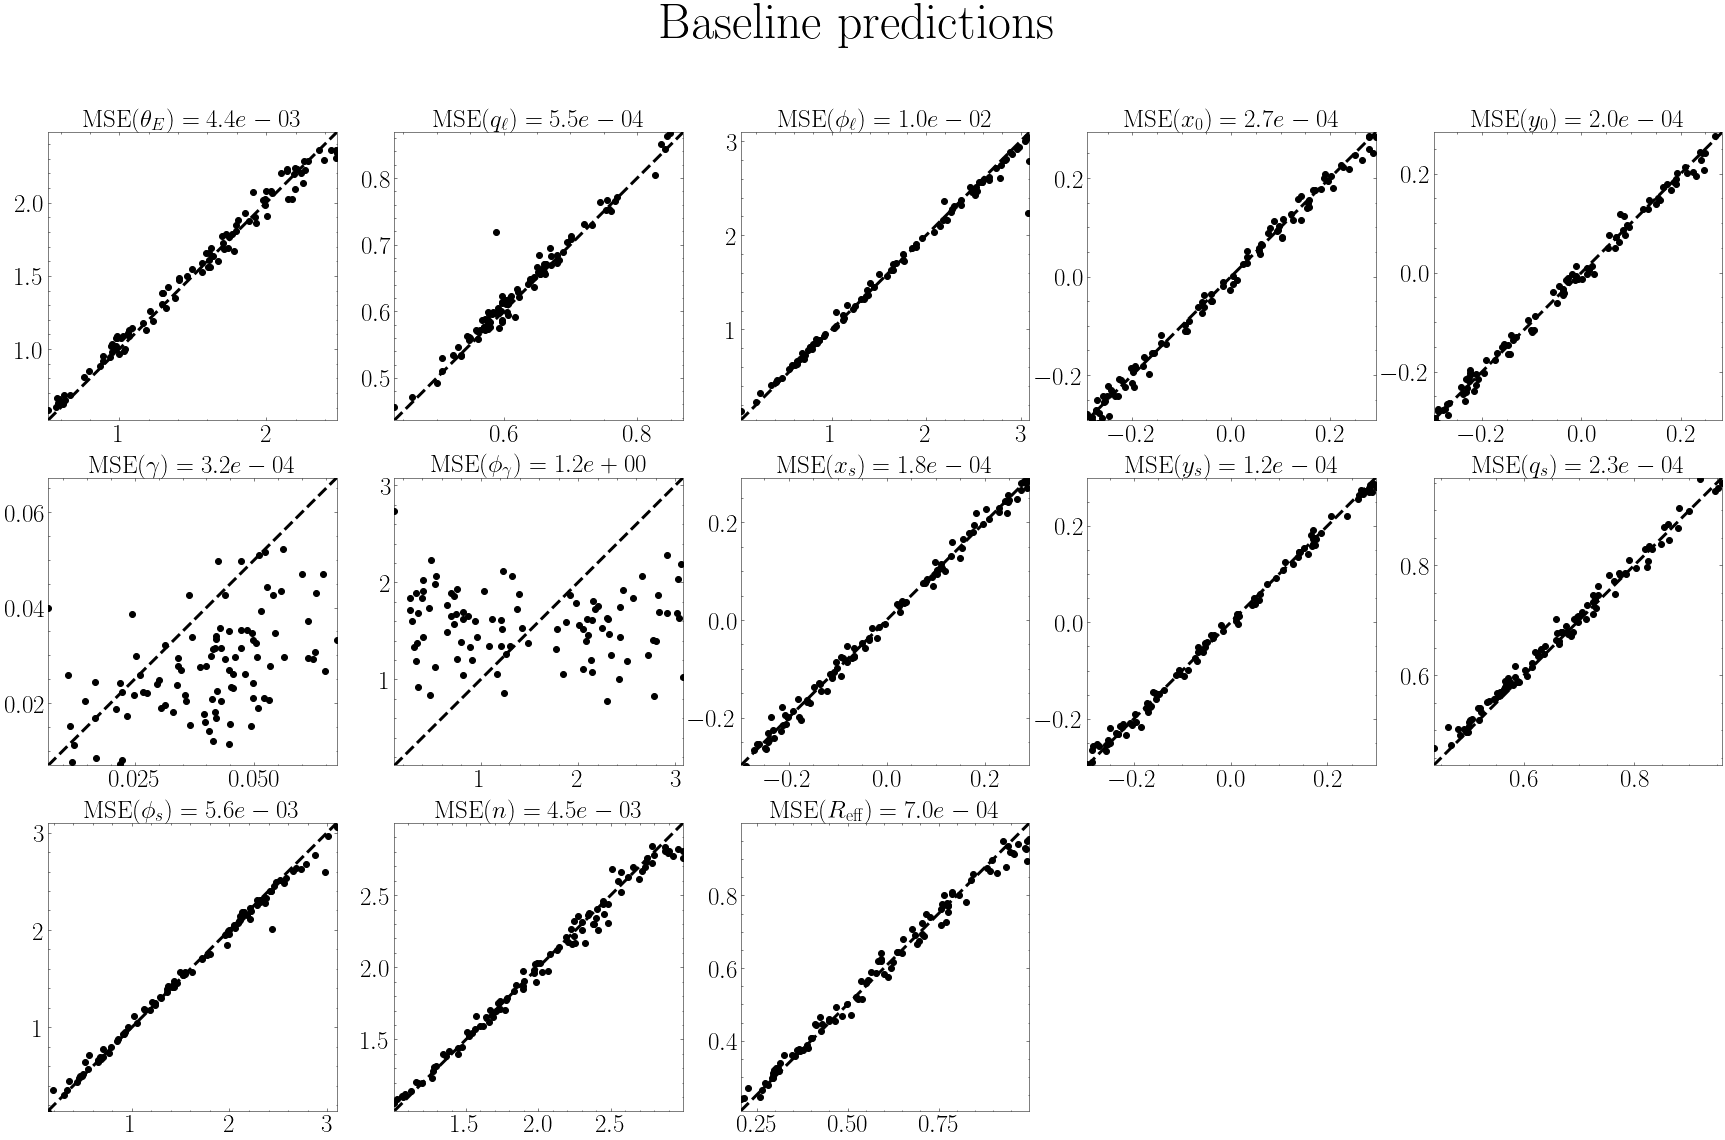

In [45]:
phys_pred_baseline = phys.model_to_physical(pred_baseline)
titles = [r"$\theta_E$", r"$q_\ell$", r"$\phi_\ell$", r"$x_0$", r"$y_0$", r"$\gamma$", r"$\phi_\gamma$", r"$x_s$", r"$y_s$", r"$q_s$", r"$\phi_s$", r"$n$", r"$R_{\mathrm{eff}}$"]
titles2 = [r"\theta_E", r"q_\ell", r"\phi_\ell", r"x_0", r"y_0", r"\gamma", r"\phi_\gamma", r"x_s", r"y_s", r"q_s", r"\phi_s", r"n", r"R_{\mathrm{eff}}"]

fig, axs = plt.subplots(3, 5, figsize=(30, 18))

for i in range(3):
    for j in range(5):
        k = 5 * i + j
        if k < 13:
#             axs[i, j].plot(true[:, k], pred[:, k], "b.", alpha=0.5)
            x_max = true[:, k].max()
            x_min = true[:, k].min()
#             axs[i, j].hexbin(true[:, k], phys.model_to_physical(pred[:, k]), cmap="twilight", extent=[x_min, x_max]*2)
            axs[i, j].plot(true[:, k], phys_pred_baseline[:, k], "ok")
            axs[i, j].plot((x_min, x_max), (x_min, x_max), "k--", lw=3)
            axs[i, j].set_title(r"$\mathrm{MSE}(%s) = %.1e$" % (titles2[k], np.mean((true[:, k] - phys_pred_baseline[:, k])**2)))
            axs[i, j].set_xlim(x_min, x_max)
            axs[i, j].set_ylim(x_min, x_max)
        if k >= 13:
            axs[i, j].axis("off")
fig.suptitle("Baseline predictions", fontsize=50);

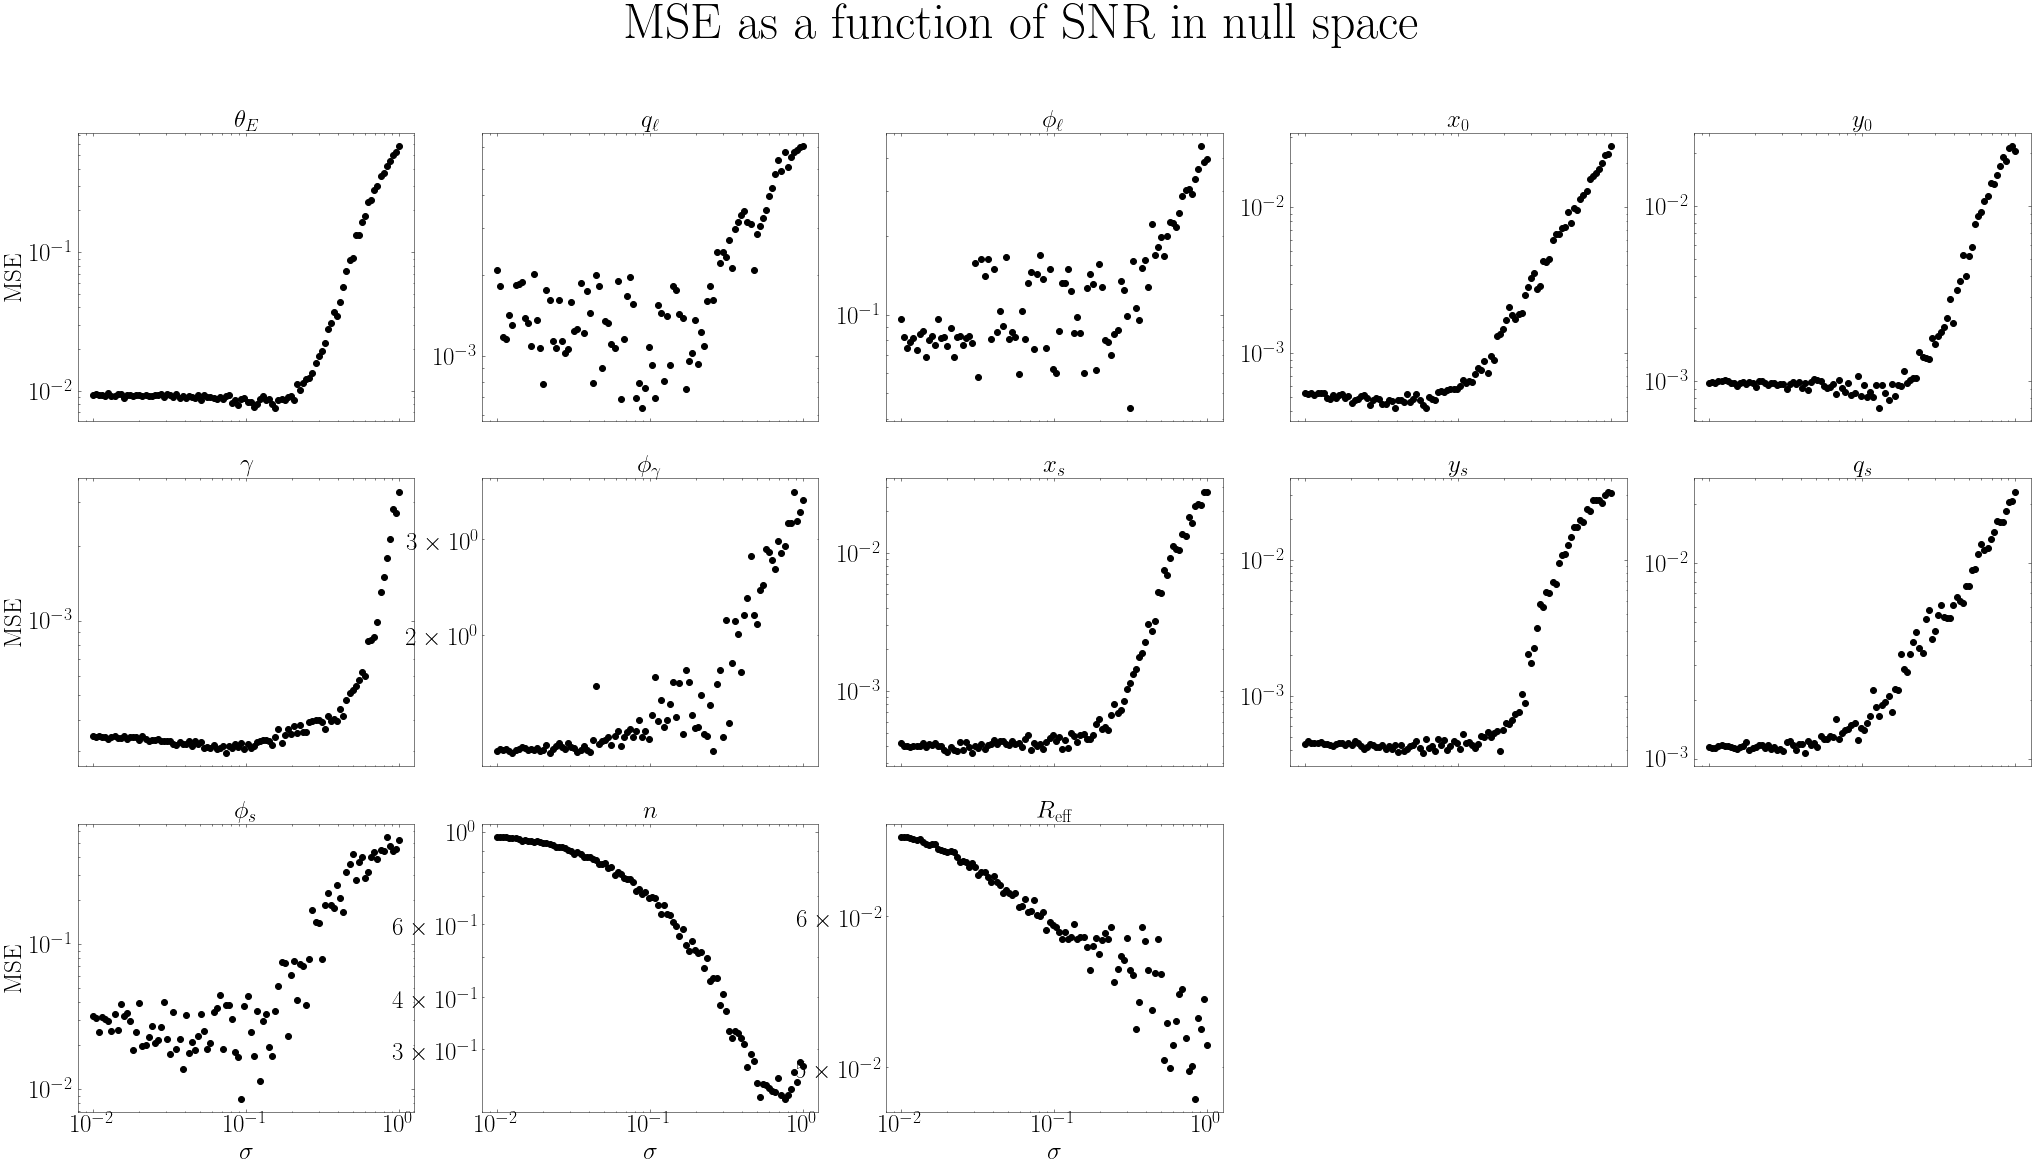

In [64]:
mse_sigmas = np.mean((true[:, None, :] - phys.model_to_physical(pred_sigmas.reshape(-1, 13)).numpy().reshape(N, len(sigmas), 13))**2, axis=0)

titles = [r"$\theta_E$", r"$q_\ell$", r"$\phi_\ell$", r"$x_0$", r"$y_0$", r"$\gamma$", r"$\phi_\gamma$", r"$x_s$", r"$y_s$", r"$q_s$", r"$\phi_s$", r"$n$", r"$R_{\mathrm{eff}}$"]
titles2 = [r"\theta_E", r"q_\ell", r"\phi_\ell", r"x_0", r"y_0", r"\gamma", r"\phi_\gamma", r"x_s", r"y_s", r"q_s", r"\phi_s", r"n", r"R_{\mathrm{eff}}"]

fig, axs = plt.subplots(3, 5, figsize=(35, 18), sharex=True)

for i in range(3): 
    for j in range(5):
        k = 5 * i + j
        if k < 13:
            axs[i, j].loglog(sigmas, mse_sigmas[:, k], "ok")
            axs[i, j].set_title(r"%s" % (titles[k]))
            axs[i, j]
        if k >= 13:
            axs[i, j].axis("off")
fig.suptitle("MSE as a function of SNR in null space", fontsize=50);
plt.setp(axs[-1, :], xlabel=r'$\sigma$')
plt.setp(axs[:, 0], ylabel=r'MSE');